# Indexing Concepts 

## Review

Before we starting pulling data lets revist the publishing overview 
presented in [Publisher](../../publishing/publishing.md) section.

![overview](../../publishing/images/example1Flow.png)

Briefly, a sitemap is made available that points the resources we will 
be indexing.  This can optionally be in a robots.txt file as well.  
This sitemap will provide a URL for each resource we will be indexing.  
It is fine if it providers more too, those resources simply wont express 
any JSON-LD content.  You can also have multiple sitemaps we ones specificly
focused on the resources to index.  

Each URL or page represented in the index are then accessed and parsed for the 
JSON-LD content.  

## Command Line Tooling

We can start exploring the indexing of data on the command line.  Here we will use the curl command which should 
be installed on all Mac OS X and Linux systems and should be found on the Linux Subsystem for Windows. 

This will give us a low level feel for what is going on.  

We will start by exploring a sitemap.  

```bash
curl -s https://samples.earth/sitemap0.xml
```

We can parse out the URLs from the sitemap with the use of the UNIX grep command

```bash
curl -s https://samples.earth/sitemap0.xml |   grep -oP '<loc>\K[^<]*'
```

In do this we see that out sitemap is really just a feed of URLs.  The sitemap provides us with the ability to add 
some extra information for our URLs.  It also providers a machine readable XML format we can work with.  There are many
libraries for working with XML and several for working with the sitemap data model in XML as well. 

Now lets pull down the URL resource and parse out the JSON-LD we find in the ```<script>``` tag of type application/ld+json.

Note, it is possible that there are many of these tags and also that this tag might be placed in by Javascript which means 
we would not see it here.  We will talk more about this as we explore.  For now we will just look for the first one and 
a static example, which we know this to be.  

```bash
curl -s  --header "Accept: text/html"   https://samples.earth/id/documents/c1pnht3h2h44frv6igfg | sed -n '/<script type=\"application\/ld+json\">/,/<\/script>/p'
```

Let's get rid of the ```<script> ``` tags and then parse the JSON-LD. 

```bash
curl -s  --header "Accept: text/html"   https://samples.earth/id/documents/c1pnht3h2h44frv6igfg | sed -n '/<script type=\"application\/ld+json\">/,/<\/script>/p' | sed 's/<\/script>//' | sed 's/<script type=\"application\/ld+json\">//'
```

TODO WORK ON THIS
At this point we could copy this JOSN-LD and visit something like the JSON-LD playground.   We could also 
visit the Structure Data Linter.   We can then play a bit with the JSON-LD there.


Now, lets pass this throgh another app.  This is the jsonld.js app.  A Javascript app and library that can be found
on GitHub at [digitalbazaar/jsonld.js](https://github.com/digitalbazaar/jsonld.js).   There are many similar libraries,
so you can feel free to try out others.  


```bash
curl -s  --header "Accept: text/html"   https://samples.earth/id/documents/c1pnht3h2h44frv6igfg | sed -n '/<script type=\"application\/ld+json\">/,/<\/script>/p' | sed 's/<\/script>//' | sed 's/<script type=\"application\/ld+json\">//' | jsonld format -q
```

If all goes well we should see the following output.

```
<https://samples.earth/id/documents/c1pnht3h2h44frv6igfg> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <https://schema.org/Dataset> .
<https://samples.earth/id/documents/c1pnht3h2h44frv6igfg> <https://schema.org/description> "of data assignments." .
<https://samples.earth/id/documents/c1pnht3h2h44frv6igfg> <https://schema.org/distribution> _:b0 .
<https://samples.earth/id/documents/c1pnht3h2h44frv6igfg> <https://schema.org/maintainer> <https://samples.earth> .
<https://samples.earth/id/documents/c1pnht3h2h44frv6igfg> <https://schema.org/name> "Fake: technical and" .
<https://samples.earth> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <https://schema.org/Organization> .
<https://samples.earth> <https://schema.org/description> "DEMO SITE:  fake data for testing" .
_:b0 <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <https://schema.org/DataDownload> .
_:b0 <https://schema.org/contentUrl> "https://samples.earth/id/documents/c1pnht3h2h44frv6igfg.tsv" .
_:b0 <https://schema.org/encodingFormat> "text/tab-separated-values" .
```

So, this was just a simple set of command line calls to give us a feel for the process.  We have seen a sitemap, the URLs 
that make it up and pulled back those URLs and parsed the JSON-LD.  We then wen ahead and converted the JSON-LD into abother
RDF represetnatikon (triples) that make loading into a graph database easier.

We could easily take these commands and roll them in a simple bash script.  This might not be a production level approach, 
but it's a good exercise and a good way to get started.  We will explore more advanced ways of doing this later.

## Python

Let's look at how this might be done in Python.  Python is a very popular language and has many solid libraries for working with JSON-LD. Again, we will use this more to get a feel for the process. 

# Imports and defs

In [1]:
import json

import requests
from bs4 import BeautifulSoup

def get_ld_json(url: str) -> dict:
    parser = "html.parser"
    req = requests.get(url)
    soup = BeautifulSoup(req.text, parser)
    return json.loads("".join(soup.find("script", {"type":"application/ld+json"}).contents))


In [2]:
import graphviz
# from conceptnet5.uri import join_uri, split_uri
API_ROOT = 'http://api.conceptnet.io'

def short_name(value, max_length=40):
    """
    Convert an RDF value (given as a dictionary) to a reasonable label.
    """
    if value['type'] == 'blank node':
        return '_'
    elif value['type'] == 'IRI':    
        url = value['value']
        if '#' in url:
            # Show just the fragment of URLs with a fragment
            # (it's probably a property name)
            return url.split('#')[-1]

        # Give URLs relative to the root of our API
        if url.startswith(API_ROOT):
            short_url = url[len(API_ROOT):]
            # If the URL is too long, hide it
            if len(short_url) > max_length:
                pieces = split_uri(short_url)
                return join_uri(pieces[0], '...')
            else:
                return short_url
        else:
            return url.split('://')[-1]
    else:
        # Put literal values in quotes
        text = value['value'].replace(':', '')
        if len(text) > max_length:
            text = text[:max_length] + '...'
        return '"{}"'.format(text)


def show_graph(url, size=10):
    """
    Show the graph structure of a ConceptNet API response.
    """
    rdf = jsonld.normalize(url)['@default']
    graph = graphviz.Digraph(
        strict=False, graph_attr={'size': str(size), 'rankdir': 'LR'}
    )
    for edge in rdf:
        subj = short_name(edge['subject'])
        obj = short_name(edge['object'])
        pred = short_name(edge['predicate'])
        if subj and obj and pred:
            # Apply different styles to the nodes based on whether they're
            # literals, ConceptNet URLs, or other URLs
            if obj.startswith('"'):
                # Literal values
                graph.node(obj, penwidth='0')
            elif obj.startswith('/'):
                # ConceptNet nodes
                graph.node(obj, style='filled', fillcolor="#ddeeff")
            else:
                # Other URLs
                graph.node(obj, color="#558855")
            graph.edge(subj, obj, label=pred)
    
    return graph

# Parse a search result

Let's do a search at the OIH test web site and then see if we can work with some of the results there.  


In [3]:
ld = get_ld_json("https://obis.org/dataset/46005357-02b8-4f17-b028-065bfc1cd384")

In [4]:
json_formatted_str = json.dumps(ld, indent=2)
print(json_formatted_str)

{
  "@context": {
    "@vocab": "https://schema.org/"
  },
  "@type": "Dataset",
  "name": "Coral Reef Evaluation and Monitoring Project Dry Tortugas 1999",
  "description": "The purpose of the Coral Reef Evaluation and Monitoring Project (CREMP) is to monitor the status and trends of selected reefs in the Florida Keys National Marine Sanctuary(FKNMS). CREMP assessments have been conducted annually at fixed sites since 1996 and data collected provides information on the temporal changes in benthic cover and diversity of stony corals and associated marine flora and fauna. The core field methods continue to be underwater videography and timed coral species inventories. Findings presented in this report include data from 109 stations at 37 sites sampled from 1996 through 2008 in the Florida Keys and 1999 through 2008 in the Dry Tortugas. The report describes the annual differences (between 2007 and 2008) in the percent cover of major benthic taxa (stony corals, octocorals, sponges, and ma

## That's big

There is a lot here, especially in the keywords section.  That's great, this will give us a lot to work with the graph.  For this demo though it might be nice to parse it down a bit.  We can take advantage of a feature of JSON-LD called "framing".  Here will make a JSON-LD frame that allows us to parse out only those elements of the document we want to work with.  Framing is vey powerful, but we will work with a simple frame for now.  One like this:

```json
 {
  "@context": {"@vocab": "https://schema.org/"},
  "@explicit": "true",
   "@type":     "Dataset",
   "name": "",
   "description": "",
   "url": "",
   "sameAs": "",
}
```

We will run this frame then look at the results and do a quick visualization using the defined function we placed at the beginning of this notebook.

{
  "@context": {
    "@vocab": "https://schema.org/"
  },
  "@type": "Dataset",
  "description": "The purpose of the Coral Reef Evaluation and Monitoring Project (CREMP) is to monitor the status and trends of selected reefs in the Florida Keys National Marine Sanctuary(FKNMS). CREMP assessments have been conducted annually at fixed sites since 1996 and data collected provides information on the temporal changes in benthic cover and diversity of stony corals and associated marine flora and fauna. The core field methods continue to be underwater videography and timed coral species inventories. Findings presented in this report include data from 109 stations at 37 sites sampled from 1996 through 2008 in the Florida Keys and 1999 through 2008 in the Dry Tortugas. The report describes the annual differences (between 2007 and 2008) in the percent cover of major benthic taxa (stony corals, octocorals, sponges, and macroalgae), mean coral species richness and the incidence of stony coral cond

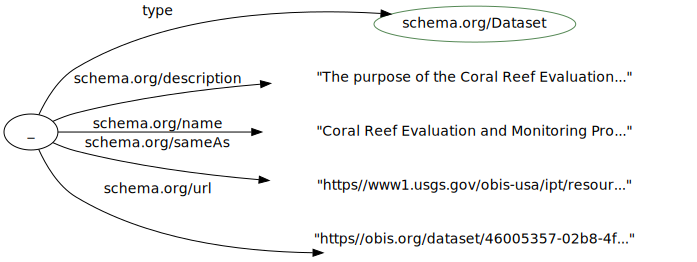

In [5]:
from pyld import jsonld
import json

frame = {
  "@context": {"@vocab": "https://schema.org/"},
  "@explicit": "true",
   "@type":     "Dataset",
   "name": "",
   "description": "",
   "url": "",
   "sameAs": "",
}


framed = jsonld.frame(ld, frame)

json_formatted_str = json.dumps(framed, indent=2)
print(json_formatted_str)

show_graph(framed)



# Conclusion

Using these approaches you could explore data from other sources you know are publishing JSON-LD.  You could improve either of the bash script or Python code to loop on the resources and store the results in files or load them directly into a triples store / graph database.  

As we continue, we will move on to the Gleaner package that is used by Ocean InfoHub and see some of the edge cases that can be addressed with it and how it fits into a more automated process.  